Project Description

The Titanic Problem is based on the sinking of the ‘Unsinkable’ ship Titanic in early 1912. It gives you information about multiple people like their ages, sexes, sibling counts, embarkment points, and whether or not they survived the disaster. 
Based on these features, you have to predict if an arbitrary passenger on Titanic would survive the sinking or not. 

Attribute Information

Passenger id- Unique Id of the passenger

Pclass- Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)

Survived- Survived (0 = No; 1 = Yes)

Name- Name of the passenger

Sex- Sex of the passenger (Male, Female)

Age- Age of the passenger

Sibsp- Number of Siblings/Spouses Aboard

Parch- Number of Parents/Children Aboard

Ticket- Ticket Number

Fare- Passenger Fare (British pound)

Cabin- Cabin

Embarked- Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve,accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics


pd.pandas.set_option('display.max_columns',None)
import warnings
warnings.filterwarnings('ignore')

Reading the dataset

In [2]:
data=pd.read_csv('https://raw.githubusercontent.com/FlipRoboTechnologies/ML-Datasets/main/Titanic/titanic_train.csv')

In [3]:
df=pd.DataFrame(data=data)

In [4]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
df.shape

(891, 12)

In [6]:
df.columns.tolist()

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

Observations

In this dataset, both numerical and categorical features are present. Total of 12 features and 891 rows are present. Since, prediction needs to be made of an individual passenger based on the features and observation, hence, the feature 'Survived' is our target variable.

Since the target variable is to predict if the passenger survived or not, it is a classification problem. As there are only 2 labels applicable, hence, logistic regression will be applied.

# Exploratory Data Analysis

Analyzing Null values

In [7]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [8]:
#Analyzing features if having any null values present

df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
#Analyzing total null values present

df.isnull().sum().sum()

866

In [10]:
# Check for null values in all features
features_with_null_value=[feature for feature in df.columns if df[feature].isnull().sum()>=1]
print('The missing value features are: ',features_with_null_value)

The missing value features are:  ['Age', 'Cabin', 'Embarked']


In [11]:
# Check for null value percentage in each feature
for feature in features_with_null_value:
    percentage=(df[feature].isnull().sum()*100)/df[feature].shape[0]
    print('The missing value percentage in {} feature is - '.format(feature), np.round(percentage,4),'%')

The missing value percentage in Age feature is -  19.8653 %
The missing value percentage in Cabin feature is -  77.1044 %
The missing value percentage in Embarked feature is -  0.2245 %


Observation

1. Features ['Age', 'Cabin', 'Embarked'] has null values present. The feature Cabin has very high percentage of null values 77.1044 %. Age has 19.8653% null values present. The Embarked embarked has very low null value present.

2. Three types of data int64,float64 and object present in the dataset.

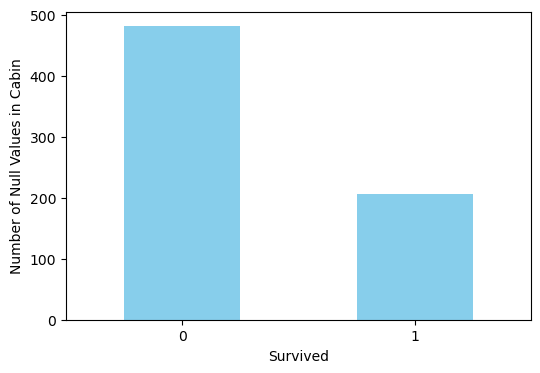

In [12]:
# Visualizing the relationship among the null values in cabin and survived 
plt.figure(figsize=(6, 4))
null_cabin_counts = df.groupby('Survived')['Cabin'].apply(lambda x: x.isnull().sum())
null_cabin_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Survived')
plt.ylabel('Number of Null Values in Cabin')
plt.xticks(rotation=0)
plt.show()

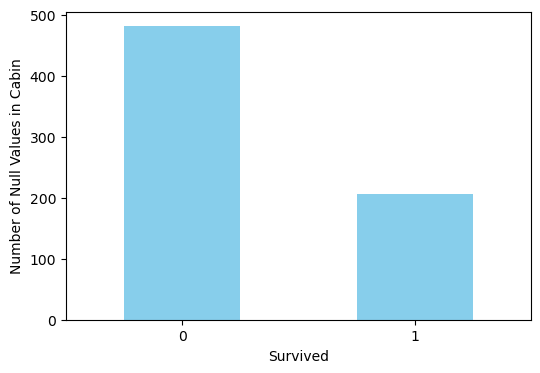

In [13]:
# Visualizing the relationship among the null values in cabin and survived 
plt.figure(figsize=(6, 4))
null_cabin_counts = df.groupby('Survived')['Cabin'].apply(lambda x: x.isnull().sum())
null_cabin_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Survived')
plt.ylabel('Number of Null Values in Cabin')
plt.xticks(rotation=0)
plt.show()

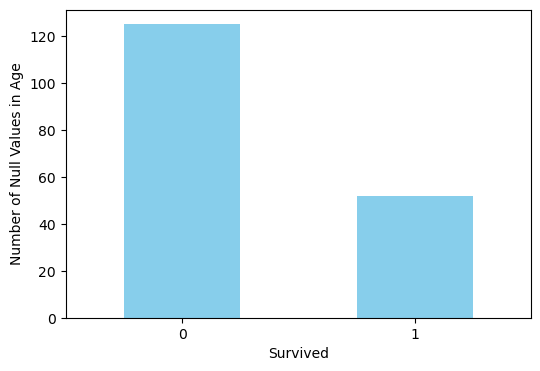

In [14]:
# Visualizing the relationship among the null values in age and survived 
plt.figure(figsize=(6, 4))
null_age_counts = df.groupby('Survived')['Age'].apply(lambda x: x.isnull().sum())
null_age_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Survived')
plt.ylabel('Number of Null Values in Age')
plt.xticks(rotation=0)
plt.show()

<Axes: >

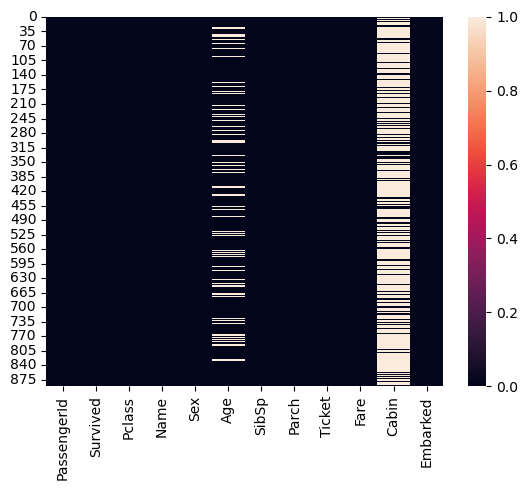

In [15]:
# Visualizing null value using heatmap

sns.heatmap(df.isnull())

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Observation

1. The feature cabin has high volume of missing values which is around 77%. Hence we can remove it from the dataset during feature selection.
2. Age has around 19.8653% missing value. The missing can be removed by applying mean or median.

Removing missing values from Age feature

<Axes: xlabel='Survived', ylabel='Age'>

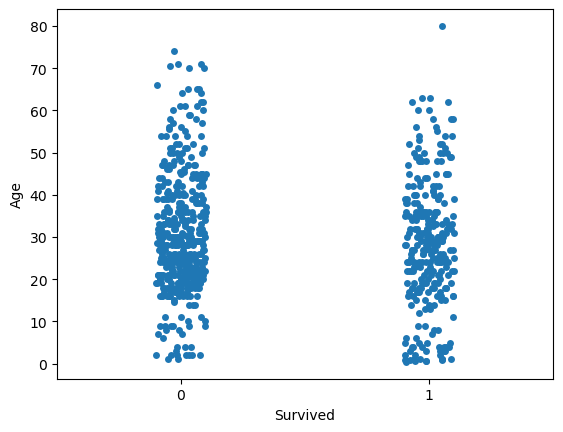

In [17]:
sns.stripplot(x='Survived',y='Age',data=df)

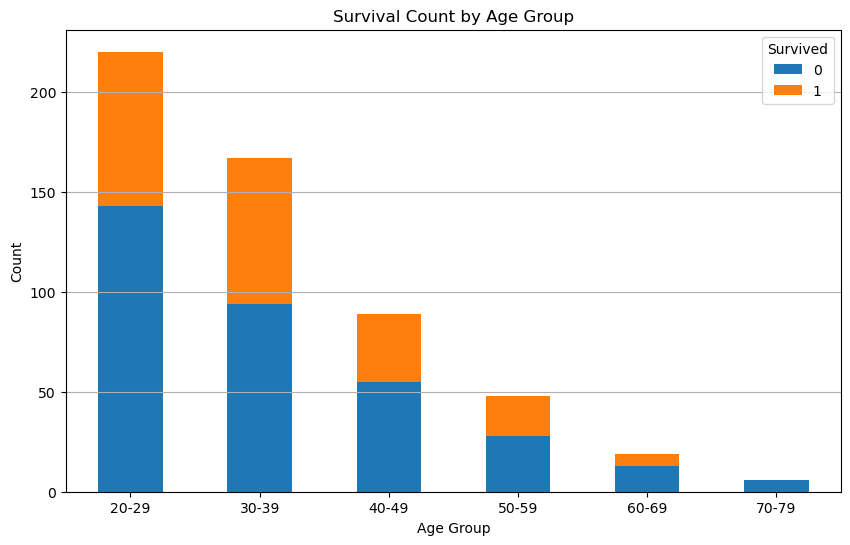

In [18]:
data=df.copy()

bins = [20, 30, 40, 50, 60, 70,80]
labels = ['20-29', '30-39', '40-49', '50-59', '60-69','70-79']
data['Age_Group'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)

grouped = data.groupby(['Age_Group', 'Survived']).size().unstack(fill_value=0)

grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Survival Count by Age Group')
plt.xticks(rotation=0)
plt.legend(title='Survived')
plt.grid(axis='y')
plt.show()

In [19]:
# Checking the value counts of Age
df['Age'].value_counts()

Age
24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: count, Length: 88, dtype: int64

In [20]:
#Calculating the median of Age
df['Age'].median()

28.0

In [21]:
#Calculating the mean of Age
df['Age'].mean()

29.69911764705882

In [22]:
# Applying median to missing the missing values

df['Age']=df['Age'].fillna(df['Age'].median())

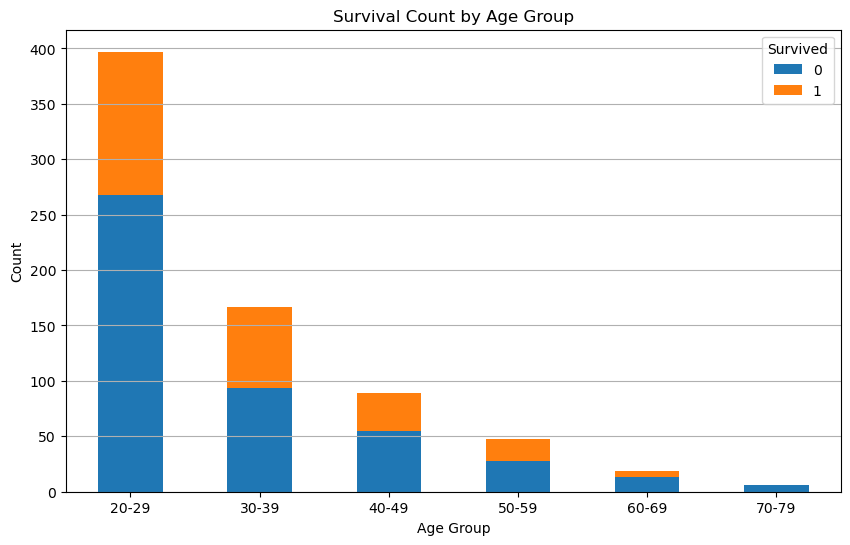

In [23]:
data=df.copy()

bins = [20, 30, 40, 50, 60, 70,80]
labels = ['20-29', '30-39', '40-49', '50-59', '60-69','70-79']
data['Age_Group'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)

grouped = data.groupby(['Age_Group', 'Survived']).size().unstack(fill_value=0)

grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Survival Count by Age Group')
plt.xticks(rotation=0)
plt.legend(title='Survived')
plt.grid(axis='y')
plt.show()

In [24]:
# Checking null values of Embarked

df.loc[df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [25]:
df['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [26]:
df['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [27]:
# Removing the null values with mode function

df['Embarked']=df['Embarked'].fillna(df['Embarked'].mode()[0])

In [28]:
df.iloc[[61,829],:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S


Observation

Null values from Age and Embarked has been removed. Median is used to in Age and mode function is used in Embarked. 

In [29]:
# Dropping the PassengerID feature

df.drop('PassengerId',axis=1,inplace=True)

In [30]:
# Dropping Cabin from the dataset 

df.drop('Cabin',axis=1,inplace=True)

In [31]:
df.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S


Observation

1. Due to presence of high volume of null values the feature Cabin has been dropped.

2. The passengerID column has unique data which act as index values only. Hence dropped.

In [32]:
# Calculating the percentage of female and male survival

female=df.loc[df['Sex']=='female']['Survived']
male=df.loc[df['Sex']=='male']['Survived']

f_percent=sum(female)*100/len(female)
m_percent=sum(male)*100/len(male)

print('{}% female survived and {}% male survived'.format(f_percent,m_percent))

74.20382165605096% female survived and 18.890814558058924% male survived


Observation

74% of all females and approx 19% of all male survived the disaster

Descriptive Statistics

In [33]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,891.0,29.361582,13.019697,0.42,22.0000,28.0000,35.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


Observation

1. Mean greater than median is observed SibSp, Parch, Fare. Hence the featurea are skewed in the right.
2. Outliers can be observed in Age, SibSp, Parch, Fare. Need to perform further analysis to establish the claim. 
3. The count is same in all the features. Hence no missing values.

Seprating Categorical and Numerical features

In [34]:
# Creating a list of numerical features
num_features=[feature for feature in df.columns if df[feature].dtypes!='O']
num_features

['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [35]:
# Creating a list of categorical features

cat_feature=[feature for feature in df.columns if df[feature].dtypes=='O']
cat_feature

['Name', 'Sex', 'Ticket', 'Embarked']

# Data Visualization

Univariate Analysis

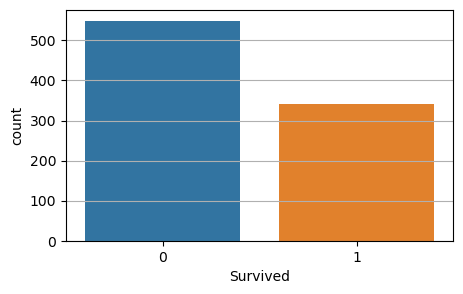

In [36]:
# Visualizing the count of Survivals
plt.figure(figsize=(5,3))
sns.countplot(x='Survived',data=df)
plt.grid(axis='y')

Death toll is much high than surviors

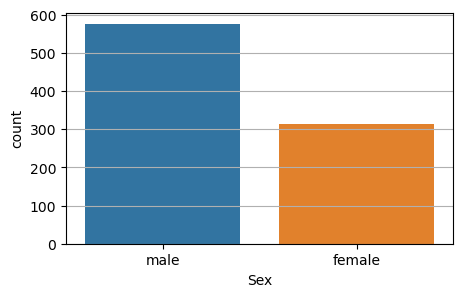

In [37]:
# Visualizing the count of Sex

plt.figure(figsize=(5,3))
sns.countplot(x='Sex',data=df)
plt.grid(axis='y')

The count of male passengers is higher than female passengers

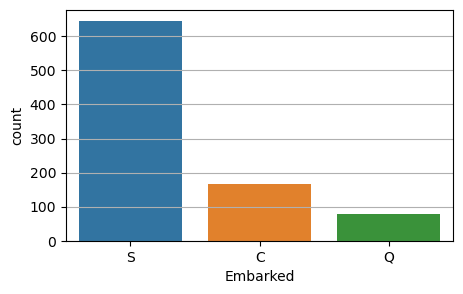

In [38]:
# Visualizing the count of Sex

plt.figure(figsize=(5,3))
sns.countplot(x='Embarked',data=df)
plt.grid(axis='y')

Passengers embarked on Southampton is very high than Cherbourg or Queenstown

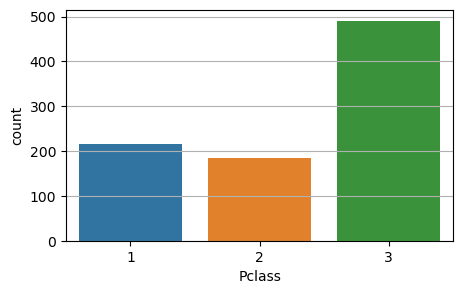

In [39]:
# Visualizing the count of Sex

plt.figure(figsize=(5,3))
sns.countplot(x='Pclass',data=df)
plt.grid(axis='y')

Passengers belongs to class 3 is very high than class 1 and class 2. The difference in count of passengers in class 1 and class 2 is moderate. 

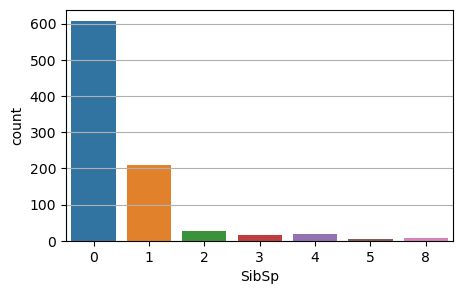

In [40]:
# Visualizing the count of Sex

plt.figure(figsize=(5,3))
sns.countplot(x='SibSp',data=df)
plt.grid(axis='y')

A large number of passenges are present on the ship without siblings or spouses. A moderate number of passengers came with 1 siblings or spouses.

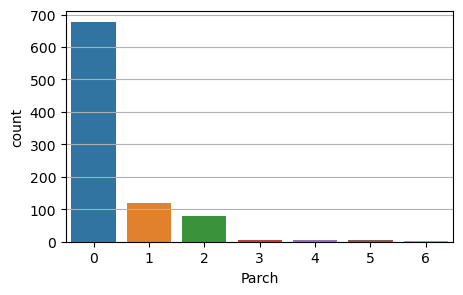

In [41]:
# Visualizing the count of Sex

plt.figure(figsize=(5,3))
sns.countplot(x='Parch',data=df)
plt.grid(axis='y')

A large number of passenges are present on the ship without parents or children.

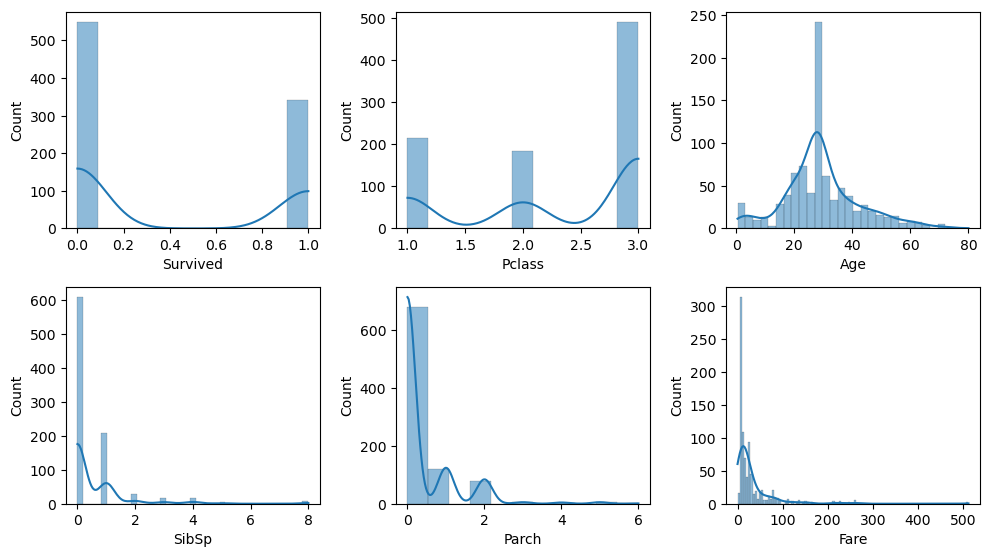

In [42]:
# Analysing distribution of numerical features 

plt.figure(figsize=(10,8))
index=1
for feature in num_features:
    if index<=len(num_features):
        plt.subplot(3,3,index)
        sns.histplot(df[feature], kde=True, linewidth=.1)
        plt.xlabel(feature)
        plt.ylabel('Count')
        index=index+1
plt.tight_layout()

From the above visualization it can be that Age looks normally distributed. The features SibSp, Parch and Fare is right skewed. Need to perform further analysis 

Bivariate analysis

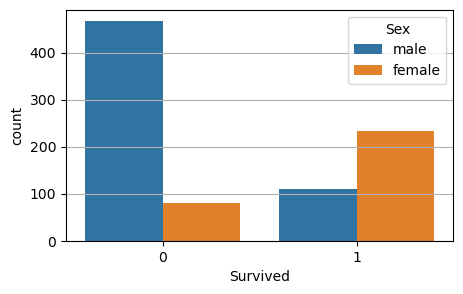

In [43]:
plt.figure(figsize=(5,3))
sns.countplot(x='Survived',data=df,hue = 'Sex')
plt.grid(axis='y')

Male death ratio is very high compared to female. The survival of female compared to male is also high

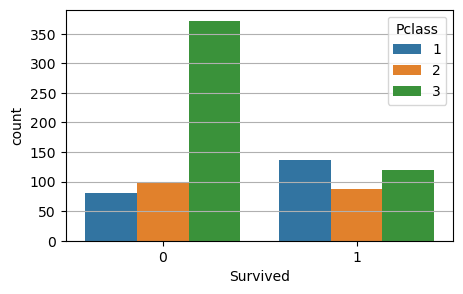

In [44]:
plt.figure(figsize=(5,3))
sns.countplot(x='Survived',hue = 'Pclass',data=df)
plt.grid(axis='y')

The death toll in class 3 passengers is very high compared to class 1 and class 2. Although in class 1 passengers in more, the survival in all 3 classes do not varies that much

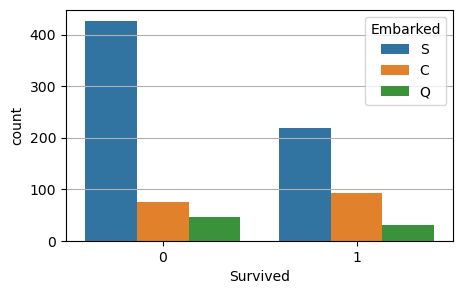

In [45]:
plt.figure(figsize=(5,3))
sns.countplot(x='Survived',data=df,hue = 'Embarked')
plt.grid(axis='y')

Both survivours and death in Southampton is high. However death toll in Southampton compared to Cherbourg and Queenstown is extremely high. 

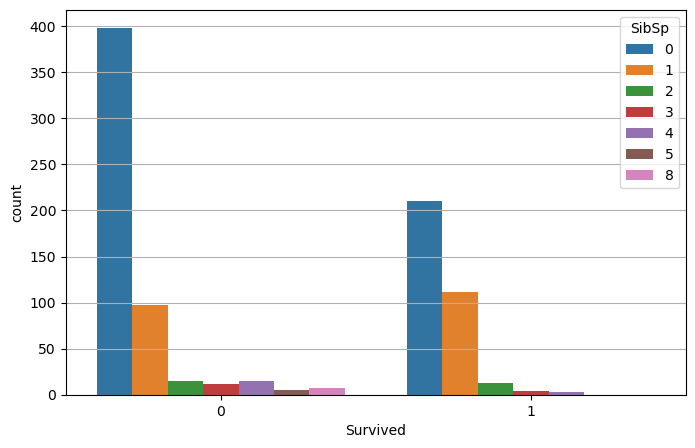

In [46]:
plt.figure(figsize=(8,5))
sns.countplot(x='Survived',hue='SibSp',data=df)
plt.grid(axis='y')

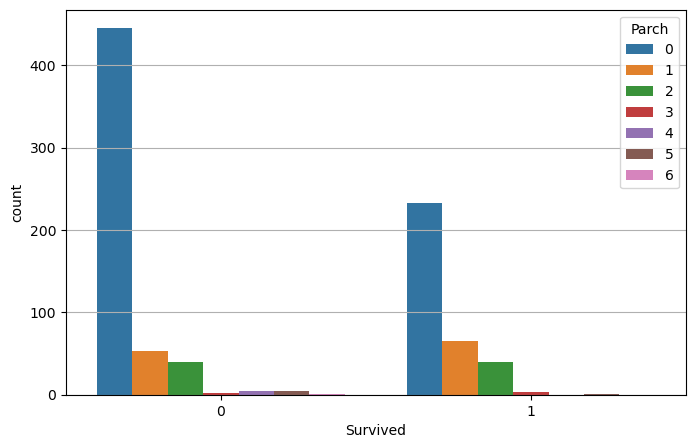

In [47]:
plt.figure(figsize=(8,5))
sns.countplot(x='Survived',hue='Parch',data=df)
plt.grid(axis='y')

Both survivours and death among single indivuduals is high. 

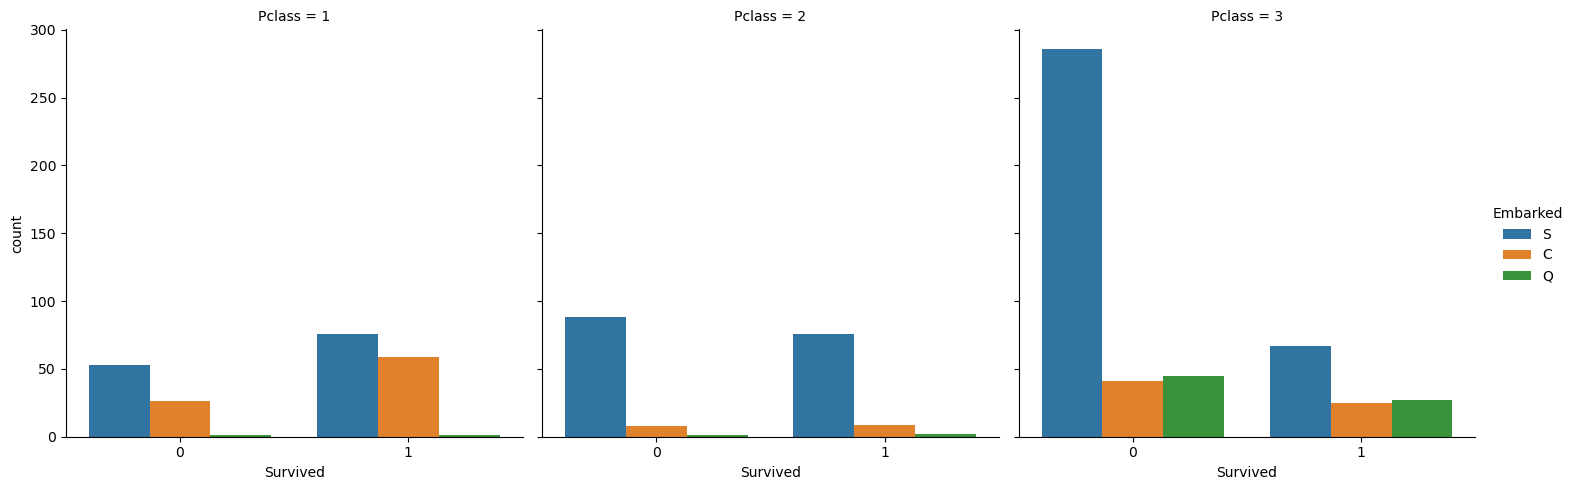

In [48]:
sns.catplot(x ='Survived', hue ='Embarked', col ='Pclass', kind ='count', data = df)

Visualizing survivors of all 3 classes based on passengers embarked

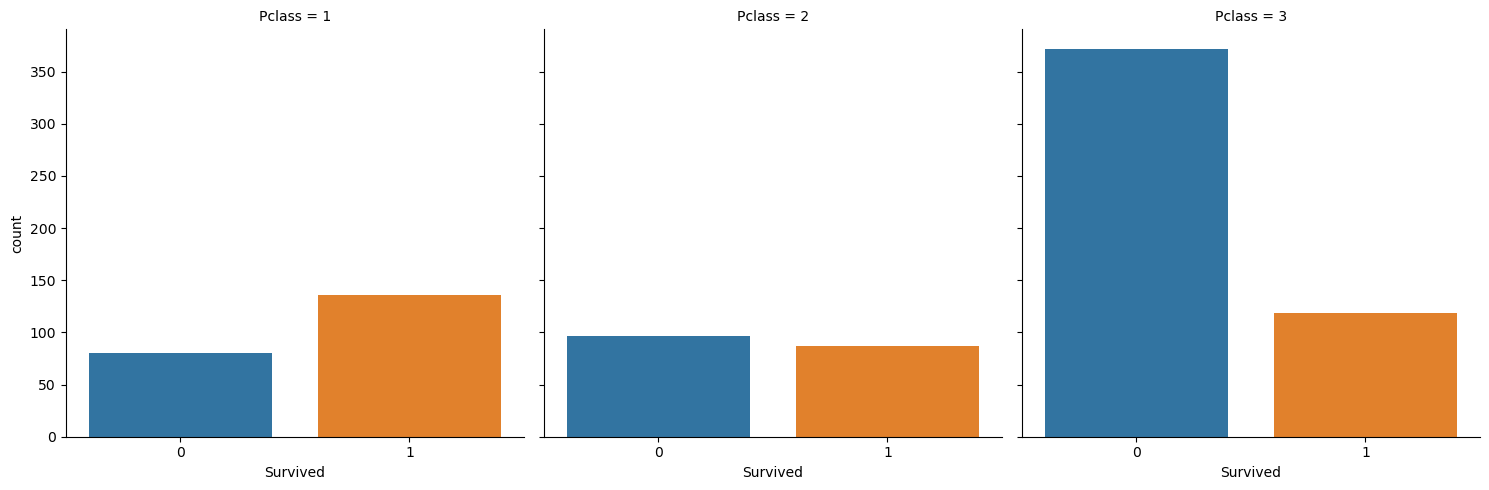

In [49]:
sns.catplot(x='Survived',col='Pclass',data=df,kind='count')

The ratio of survivors to death is more in class 1 passengers. In class 2 passengers although the death toll is more the difference is not much. In class 3 passengers the death toll is very high compared to survivous.

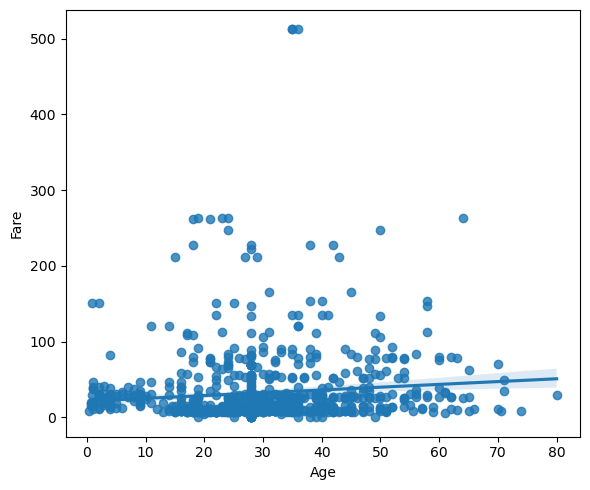

In [50]:
# Checking linear relationship amoung fare and age
plt.figure(figsize=(6,5))
sns.regplot(x=df['Age'],y=df['Fare'])
plt.tight_layout()

Not much relationship can be observed between passenger's age and fare

Multivariate analysis

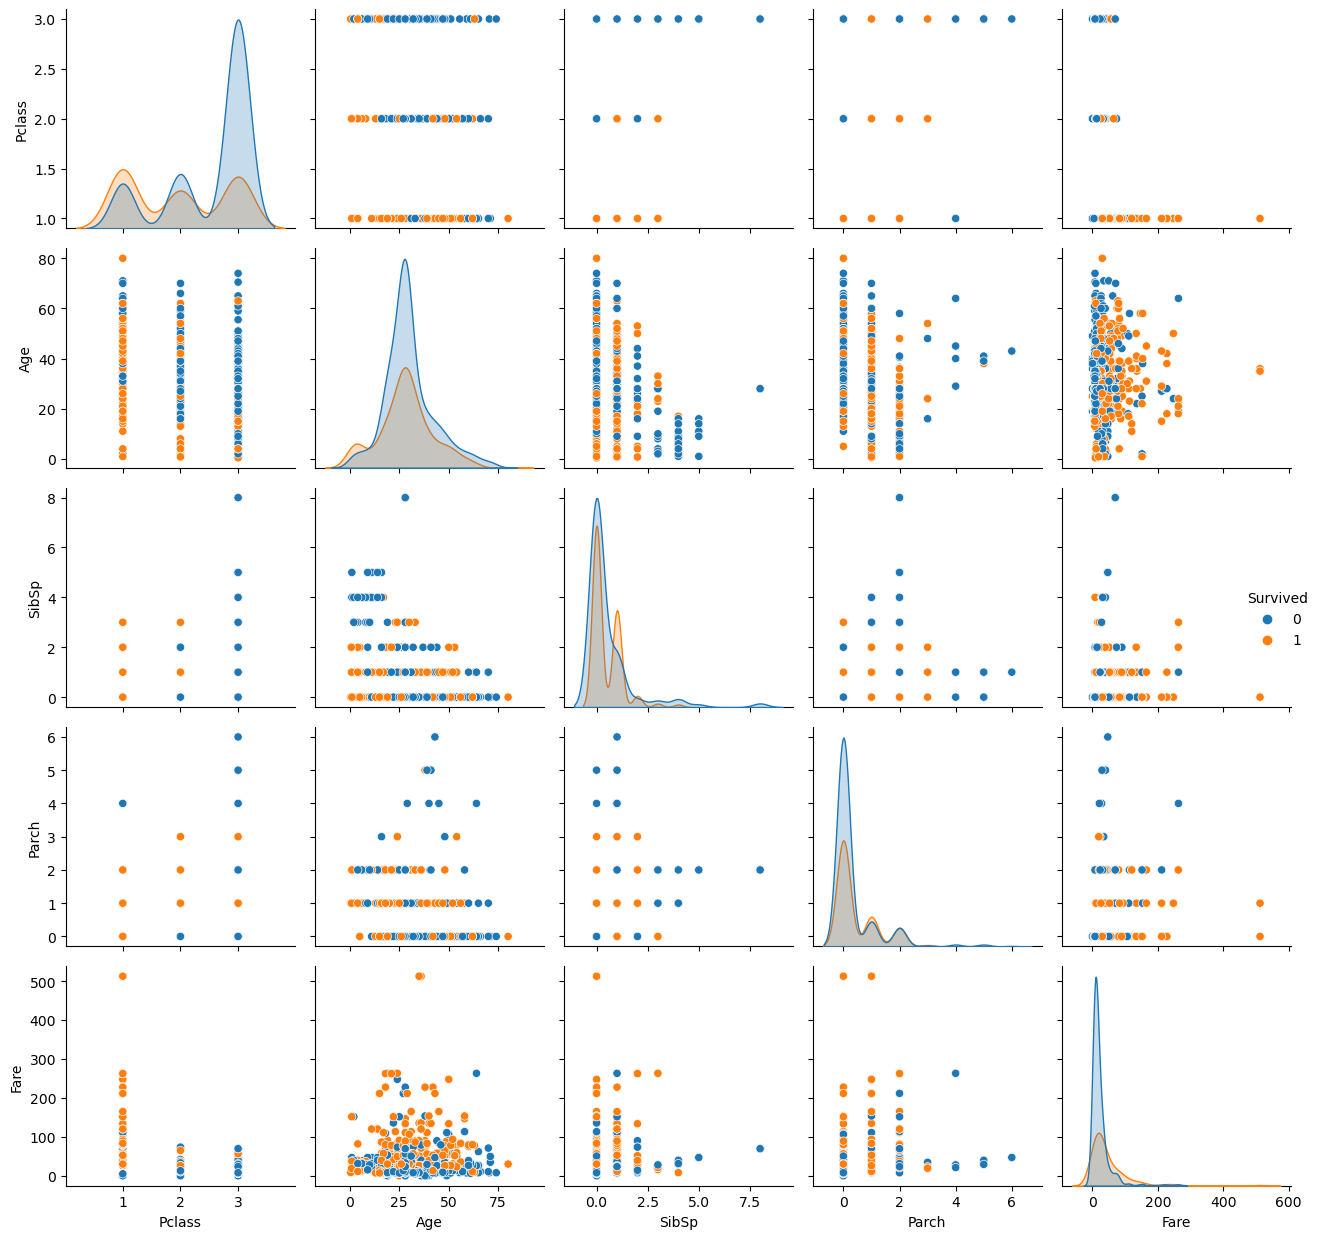

In [51]:
# Creating a pairplot

sns.pairplot(df,hue='Survived')
plt.tight_layout()

Some outliers can be observed in few features. Need to perform further analysis.

Outliers Detection

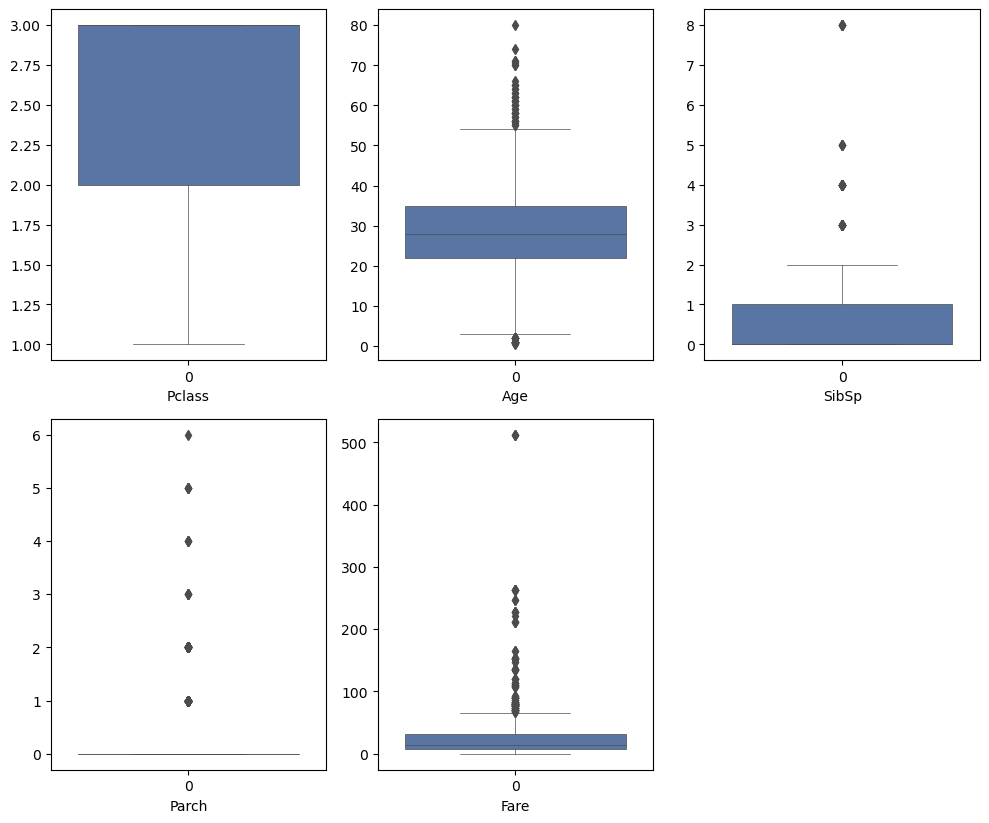

In [52]:
# Checking for the presence of outliers 
plt.figure(figsize=(10,12))
data=df.copy()
index=1
for feature in num_features:
    if index<=9 and feature not in 'Survived':
        plt.subplot(3,3,index)
        sns.boxplot(data=data[feature], palette='deep', linewidth=.5)
        plt.xlabel(feature)
        index+=1
plt.tight_layout()      
        

1. In the feature Age and Fare presence of outliers can be observed. 
2. Outliers can be observed in features SibSp and Parch. However, since these features are discrete numerical features, hence no need to remove outliers.

In [53]:
def outliers_detection(data):
    z_score=np.abs(zscore(data[['Age','Fare']]))
    print(np.where(z_score>3))
    return z_score

In [54]:
z_score=outliers_detection(df)
z_score

(array([ 27,  88,  96, 116, 118, 258, 299, 311, 341, 377, 380, 438, 493,
       527, 557, 630, 672, 679, 689, 700, 716, 730, 737, 742, 745, 779,
       851], dtype=int64), array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0], dtype=int64))


,Age,Fare
0,0.565736,0.502445
1,0.663861,0.786845
2,0.258337,0.488854
3,0.433312,0.420730
4,0.433312,0.486337
...,...,...
886,0.181487,0.386671
887,0.796286,0.044381
888,0.104637,0.176263
889,0.258337,0.044381


In [55]:
def removing_outliers(z_score,data):
    data=data[(z_score<3).all(axis=1)]
    return data

In [56]:
#Calculating the total data loss
total_data_loss=df.shape[0]-data.shape[0]
print('The total data lost due to outliers is:', total_data_loss)

The total data lost due to outliers is: 0


In [57]:
#Calculating the percentage of data loss
total_data=df.shape[0]
percent=total_data_loss*100/total_data
print('Total percentage of data lost is: {:.2f}%'.format(percent))

Total percentage of data lost is: 0.00%


In [58]:
# Assigning the outlier free dataset to df
df=data

Skewness

In [59]:
# Checking skewness in the dataset

df[num_features].skew()

Survived    0.478523
Pclass     -0.630548
Age         0.510245
SibSp       3.695352
Parch       2.749117
Fare        4.787317
dtype: float64

Skewness is observed in SibSp, Parch and Fare. Fare is the only continuous feature among the three, hence, we log transformation will be used to remove skewness

In [60]:
df['Fare']=np.log(df['Fare']+1)

In [61]:
df[num_features].skew()

Survived    0.478523
Pclass     -0.630548
Age         0.510245
SibSp       3.695352
Parch       2.749117
Fare        0.394928
dtype: float64

Observation

Skewness has been removed from the dataset

Feature selection

In [62]:
# Removing features Name and Ticket

df.drop('Name',axis=1,inplace=True)
df.drop('Ticket',axis=1,inplace=True)

In [63]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

The features passenger name and Ticket no. has no direct relationship with passenger survival. Hence, the features are removed.

Encoding categorical columns

In [64]:
df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,2.110213,S
1,1,1,female,38.0,1,0,4.280593,C
2,1,3,female,26.0,0,0,2.188856,S


In [65]:
# Encoding Sex using LabelEncoder
le= LabelEncoder()
df['Sex']=le.fit_transform(df['Sex'])

In [66]:
# Encoding Embarked using LabelEncoder
le=LabelEncoder()
df['Embarked']=le.fit_transform(df['Embarked'])

In [67]:
df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,2.110213,2
1,1,1,0,38.0,1,0,4.280593,0
2,1,3,0,26.0,0,0,2.188856,2


Using LabelEncoder feature Sex and Embarked has been transformed.

Checking correlation among features

In [68]:
df.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Survived,1.000000,-0.338481,-0.543351,-0.064910,-0.035322,0.081629,0.329862,-0.167675
Pclass,-0.338481,1.000000,0.131900,-0.339898,0.083081,0.018443,-0.661022,0.162098
Sex,-0.543351,0.131900,1.000000,0.081163,-0.114631,-0.245489,-0.263276,0.108262
Age,-0.064910,-0.339898,0.081163,1.000000,-0.233296,-0.172482,0.110964,-0.018754
SibSp,-0.035322,0.083081,-0.114631,-0.233296,1.000000,0.414838,0.318528,0.068230
Parch,0.081629,0.018443,-0.245489,-0.172482,0.414838,1.000000,0.332186,0.039798
Fare,0.329862,-0.661022,-0.263276,0.110964,0.318528,0.332186,1.000000,-0.202444
Embarked,-0.167675,0.162098,0.108262,-0.018754,0.068230,0.039798,-0.202444,1.000000


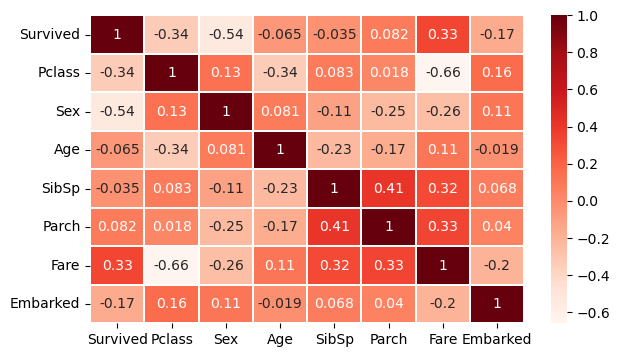

In [69]:
plt.figure(figsize=(7,4))
sns.heatmap(df.corr(),fmt='.2g',annot=True,linewidth=.2,cmap='Reds')
plt.show()

Observations

1. It can be observed that survided it moderately positve correlated with Fare.
2. Parch shows no correlation with survived.
3. All features except above two shows moderate to low negative correlation with survived.

Separating the Dependent and Independent features

In [70]:
x=df.iloc[:,1:]
y=df.iloc[:,0]

Scaling the independent features using StandardScaler Technique

In [71]:
def scaling_stdScaler(x):
    st=StandardScaler()
    x=pd.DataFrame(st.fit_transform(x),columns=x.columns)
    return x

In [72]:
#Calling the scaling_stdScaler function and assigning to x
x=scaling_stdScaler(x)

Standard scaling will transfor the values of the dataset into same scale. It will help in improving the model performance and ensure that the data is in the same scale.

Variance Inflation Factor

In [73]:
def vif_calc(x):
    vif=pd.DataFrame()
    vif['Features']=x.columns
    vif['VIF Factors']=[VIF(x.values,i) for i in range(x.shape[1])]
    
    return vif

In [74]:
vif_calc(x)

,Features,VIF Factors
0,Pclass,2.412087
1,Sex,1.123709
2,Age,1.211684
3,SibSp,1.476167
4,Parch,1.402156
5,Fare,2.784858
6,Embarked,1.080065


Observation

Based on the variance inflation factor (VIF) values, it seems that multicollinearity is not severe among the features in the dataset. Generally, VIF values below 5 are considered acceptable, indicating that multicollinearity is not a significant concern.


Oversampling the data

In [75]:
y.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

The dependent feature has imbalanced dataset. Hence we need to perform oversampling

In [76]:
sm=SMOTE()
x,y=sm.fit_resample(x,y)

In [77]:
y.value_counts()

Survived
0    549
1    549
Name: count, dtype: int64

The data has been balanced. We can perform classification modelling

# Modelling

In [78]:
def random_state_cal(x,y):
    best_randomstate = None
    best_score = 0
    
    for rs in range(1,201):
        x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.3,random_state=rs)
        model_lr=LogisticRegression()
        model_lr.fit(x_train,y_train)
        pred=model_lr.predict(x_test)
        score=accuracy_score(y_test,pred)
        
        if score>best_score:
            best_score=score
            best_randomstate=rs
    print('R2 Score :{} Random state :{}'.format(best_score,best_randomstate))

In [79]:
random_state_cal(x,y)

R2 Score :0.8242424242424242 Random state :6


Applying train_test_split with test_size=.30 and random_state=64

In [80]:
x_train,x_test,y_train,y_test=train_test_split(x, y,test_size=.30, random_state=64)

Logistic Regression

In [81]:
def logistic_regression(x_train,x_test,y_train,y_test):
    
    lr=LogisticRegression()
    lr.fit(x_train,y_train)
    lg_pred=lr.predict(x_test)
    
    acc_lr=accuracy_score(y_test,lg_pred)
    print('The accuracy using Logistic regression is: {:4f}% '.format((accuracy_score(y_test,lg_pred))*100))
    print(confusion_matrix(y_test,lg_pred))
    print(classification_report(y_test,lg_pred))
    
    return lg_pred, acc_lr

In [82]:
lg_pred, acc_lr = logistic_regression(x_train,x_test,y_train,y_test)

The accuracy using Logistic regression is: 79.090909% 
[[141  25]
 [ 44 120]]
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       166
           1       0.83      0.73      0.78       164

    accuracy                           0.79       330
   macro avg       0.79      0.79      0.79       330
weighted avg       0.79      0.79      0.79       330



Support Vector Classifier

In [83]:
def support_vector(x_train,x_test,y_train,y_test):
    
    svc=SVC()
    svc.fit(x_train,y_train)
    svc_pred=svc.predict(x_test)
    
    acc_svc=accuracy_score(y_test,svc_pred)
    print('The accuracy using SVC is: {:4f}% '.format((accuracy_score(y_test,svc_pred))*100))
    print(confusion_matrix(y_test,svc_pred))
    print(classification_report(y_test,svc_pred))
    
    return svc_pred, acc_svc

In [84]:
svc_pred, acc_svc=support_vector(x_train,x_test,y_train,y_test)

The accuracy using SVC is: 82.121212% 
[[147  19]
 [ 40 124]]
              precision    recall  f1-score   support

           0       0.79      0.89      0.83       166
           1       0.87      0.76      0.81       164

    accuracy                           0.82       330
   macro avg       0.83      0.82      0.82       330
weighted avg       0.83      0.82      0.82       330



Random Forest Classifier

In [85]:
def random_forest(x_train,x_test,y_train,y_test):
    
    rfc=RandomForestClassifier()
    rfc.fit(x_train,y_train)
    rfc_pred=rfc.predict(x_test)
    
    acc_rfc=accuracy_score(y_test,rfc_pred)
    print('The accuracy using SVC is: {:4f}% '.format((accuracy_score(y_test,rfc_pred))*100))
    print(confusion_matrix(y_test,rfc_pred))
    print(classification_report(y_test,rfc_pred))
    
    return rfc_pred,acc_rfc

In [86]:
rfc_pred,acc_rfc = random_forest(x_train,x_test,y_train,y_test)

The accuracy using SVC is: 83.030303% 
[[144  22]
 [ 34 130]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       166
           1       0.86      0.79      0.82       164

    accuracy                           0.83       330
   macro avg       0.83      0.83      0.83       330
weighted avg       0.83      0.83      0.83       330



Adaboost Classifier

In [87]:
def adaboost(x_train,x_test,y_train,y_test):
    
    abc=AdaBoostClassifier()
    abc.fit(x_train,y_train)
    abc_pred=abc.predict(x_test)
    
    acc_abc=accuracy_score(y_test,abc_pred)
    print('The accuracy using SVC is: {:4f}% '.format((accuracy_score(y_test,abc_pred))*100))
    print(confusion_matrix(y_test,abc_pred))
    print(classification_report(y_test,abc_pred))
    
    return abc_pred, acc_abc

In [88]:
abc_pred, acc_abc = adaboost(x_train,x_test,y_train,y_test)

The accuracy using SVC is: 79.696970% 
[[138  28]
 [ 39 125]]
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       166
           1       0.82      0.76      0.79       164

    accuracy                           0.80       330
   macro avg       0.80      0.80      0.80       330
weighted avg       0.80      0.80      0.80       330



Gradient Boosting Classifier

In [89]:
def gradientboost(x_train,x_test,y_train,y_test):
    
    gbc=GradientBoostingClassifier()
    gbc.fit(x_train,y_train)
    gbc_pred=gbc.predict(x_test)
    
    acc_gbc=accuracy_score(y_test,gbc_pred)
    print('The accuracy using SVC is: {:4f}% '.format((accuracy_score(y_test,gbc_pred))*100))
    print(confusion_matrix(y_test,gbc_pred))
    print(classification_report(y_test,gbc_pred))
    
    return gbc_pred,acc_gbc

In [90]:
gbc_pred, acc_gbc = gradientboost(x_train,x_test,y_train,y_test)

The accuracy using SVC is: 82.727273% 
[[151  15]
 [ 42 122]]
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       166
           1       0.89      0.74      0.81       164

    accuracy                           0.83       330
   macro avg       0.84      0.83      0.83       330
weighted avg       0.84      0.83      0.83       330



Bagging classifier

In [91]:
def baggingclassifier(x_train,x_test,y_train,y_test):
    
    bc=BaggingClassifier()
    bc.fit(x_train,y_train)
    bc_pred=bc.predict(x_test)
    
    acc_bc=accuracy_score(y_test,bc_pred)
    print('The accuracy using SVC is: {:4f}% '.format((accuracy_score(y_test,bc_pred))*100))
    print(confusion_matrix(y_test,bc_pred))
    print(classification_report(y_test,bc_pred))
    
    return bc_pred,acc_bc

In [92]:
bc_pred, acc_bc = baggingclassifier(x_train,x_test,y_train,y_test)

The accuracy using SVC is: 81.515152% 
[[146  20]
 [ 41 123]]
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       166
           1       0.86      0.75      0.80       164

    accuracy                           0.82       330
   macro avg       0.82      0.81      0.81       330
weighted avg       0.82      0.82      0.81       330



Extra tree classifier

In [93]:
def extratree_classifier(x_train,x_test,y_train,y_test):
    
    etc=ExtraTreesClassifier()
    etc.fit(x_train,y_train)
    etc_pred=etc.predict(x_test)
    
    acc_etc=accuracy_score(y_test,etc_pred)
    print('The accuracy using SVC is: {:4f}% '.format((accuracy_score(y_test,etc_pred))*100))
    print(confusion_matrix(y_test,etc_pred))
    print(classification_report(y_test,etc_pred))
    
    return etc_pred, acc_etc

In [94]:
etc_pred, acc_etc=extratree_classifier(x_train,x_test,y_train,y_test)

The accuracy using SVC is: 82.424242% 
[[146  20]
 [ 38 126]]
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       166
           1       0.86      0.77      0.81       164

    accuracy                           0.82       330
   macro avg       0.83      0.82      0.82       330
weighted avg       0.83      0.82      0.82       330



In [95]:
def decisiontree_classifier(x_train,x_test,y_train,y_test):
    
    dtc=DecisionTreeClassifier()
    dtc.fit(x_train,y_train)
    dtc_pred=dtc.predict(x_test)
    
    acc_dtc=accuracy_score(y_test,dtc_pred)
    print('The accuracy using SVC is: {:4f}% '.format((accuracy_score(y_test,dtc_pred))*100))
    print(confusion_matrix(y_test,dtc_pred))
    print(classification_report(y_test,dtc_pred))
    
    return dtc_pred, acc_dtc

In [96]:
dtc_pred, acc_dtc = decisiontree_classifier(x_train,x_test,y_train,y_test)

The accuracy using SVC is: 77.575758% 
[[136  30]
 [ 44 120]]
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       166
           1       0.80      0.73      0.76       164

    accuracy                           0.78       330
   macro avg       0.78      0.78      0.78       330
weighted avg       0.78      0.78      0.78       330



In [97]:
def knn(x_train,x_test,y_train,y_test):
    
    knn=KNeighborsClassifier()
    knn.fit(x_train,y_train)
    knn_pred=knn.predict(x_test)
    
    acc_knn=accuracy_score(y_test,knn_pred)
    print('The accuracy using KNN is: {:4f}% '.format((accuracy_score(y_test,knn_pred))*100))
    print(confusion_matrix(y_test,knn_pred))
    print(classification_report(y_test,knn_pred))
    
    return knn_pred, acc_knn

In [98]:
knn_pred, acc_knn = knn(x_train,x_test,y_train,y_test)

The accuracy using KNN is: 80.000000% 
[[138  28]
 [ 38 126]]
              precision    recall  f1-score   support

           0       0.78      0.83      0.81       166
           1       0.82      0.77      0.79       164

    accuracy                           0.80       330
   macro avg       0.80      0.80      0.80       330
weighted avg       0.80      0.80      0.80       330



# Cross validating all the models

In [99]:
def cross_validation(x,y,*args):
    
    # Cross validation for Logistic Regression
    lg=LogisticRegression()
    lg_score=cross_val_score(lg,x,y)
    diff_lr=accuracy_score(y_test,lg_pred)-lg_score.mean()
    
    # Cross SVC
    svc=SVC()
    svc_score=cross_val_score(svc,x,y)
    diff_svc=accuracy_score(y_test,svc_pred)-lg_score.mean()
    
    # Cross validation for RandomForestClassifier
    rfc=RandomForestClassifier()
    rfc_score=cross_val_score(rfc,x,y)
    diff_rfc=accuracy_score(y_test,rfc_pred)-rfc_score.mean()
    
    # Cross validation for AdaBoostClassifier
    abc=AdaBoostClassifier()
    abc_score=cross_val_score(abc,x,y)
    diff_abc=accuracy_score(y_test,abc_pred)-abc_score.mean()
    
    # Cross validation for GradientBoostingClassifier
    gbc=GradientBoostingClassifier()
    gbc_score=cross_val_score(gbc,x,y)
    diff_gbc=accuracy_score(y_test,gbc_pred)-gbc_score.mean()
    
    # Cross validation for BaggingClassifier
    bc=BaggingClassifier()
    bc_score=cross_val_score(bc,x,y)
    diff_bc=accuracy_score(y_test,bc_pred)-bc_score.mean()
    
    # Cross validation for ExtraTreesClassifier
    etc=ExtraTreesClassifier()
    etc_score=cross_val_score(etc,x,y)
    diff_etc=accuracy_score(y_test,etc_pred)-etc_score.mean()
    
    # Cross validation for DecisionTreeClassifier
    dtc=DecisionTreeClassifier()
    dtc_score=cross_val_score(dtc,x,y)
    diff_dtc=accuracy_score(y_test,dtc_pred)-dtc_score.mean()
    
    # Cross validation for KNeighborsClassifier
    knn=KNeighborsClassifier()
    knn_score=cross_val_score(knn,x,y)
    diff_knn=accuracy_score(y_test,knn_pred)-knn_score.mean()
    
    df=pd.DataFrame({'Classification Name':['Logistic Regression',
                                        'SVC',
                                        'RandomForestClassifier',
                                        'AdaBoostClassifier',
                                        'GradientBoostingClassifier',
                                        'BaggingClassifier',
                                        'ExtraTreesClassifier',
                                        'DecisionTreeClassifier',
                                        'KNeighborsClassifier'],
                     'Classification Score':[acc_lr, acc_svc, acc_rfc, acc_abc, acc_gbc, acc_bc, acc_etc, acc_dtc, acc_knn],
                     'Cross Val Score':[lg_score.mean(), 
                                        svc_score.mean(), 
                                        rfc_score.mean(), 
                                        abc_score.mean(), 
                                        gbc_score.mean(), 
                                        bc_score.mean(), 
                                        etc_score.mean(), 
                                        dtc_score.mean(), 
                                        knn_score.mean()],
                     'Difference': [diff_lr, diff_svc, diff_rfc, diff_abc, diff_gbc, diff_bc, diff_etc, diff_dtc, diff_knn]
                    })
    return df

In [100]:
model_pred=[lg_pred, svc_pred, rfc_pred, abc_pred, gbc_pred, bc_pred, etc_pred, dtc_pred, knn_pred]

In [101]:
cross_validation(x,y,model_pred)

,Classification Name,Classification Score,Cross Val Score,Difference
0,Logistic Regression,0.790909,0.776891,0.014018
1,SVC,0.821212,0.795122,0.044321
2,RandomForestClassifier,0.830303,0.825189,0.005114
3,AdaBoostClassifier,0.796970,0.801494,-0.004525
4,GradientBoostingClassifier,0.827273,0.816974,0.010299
5,BaggingClassifier,0.815152,0.825189,-0.010037
6,ExtraTreesClassifier,0.824242,0.817891,0.006351
7,DecisionTreeClassifier,0.775758,0.797887,-0.022130
8,KNeighborsClassifier,0.800000,0.816073,-0.016073


Observation

We have observed that both Gradient Boosting Classifier model and Random Forest Classifier model are performing well. Both the models also have almost similar performance. 

As, Random Forest Classifier is performing little better. Hence, Random Forest Classifier as the best model for the dataset.

# Hyper Parameter tuning

In [117]:
parameters = {'n_estimators': [50, 100, 150, 200, 250, 300],  
              'criterion':['gini', 'entropy'],
               'max_depth': [None, 10, 20, 30],  
               'max_features': ['auto', 'sqrt'],  
               'bootstrap': [True, False],
               'n_jobs': [-2, -1, 1],
               'random_state':[39,42,64,66,68]
}

In [118]:
gridsearch_cv=GridSearchCV(RandomForestClassifier(),parameters,cv=5)


In [119]:
gridsearch_cv.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [100, 150, 200, 250],
                         'n_jobs': [-2, -1, 1]})

In [120]:
gridsearch_cv.best_params_

{'criterion': 'entropy', 'n_estimators': 100, 'n_jobs': -1}

In [121]:
final_model=RandomForestClassifier(criterion='entropy',n_estimators=100,n_jobs=-1,random_state=64)
final_model.fit(x_train,y_train)
pred=final_model.predict(x_test)
print(accuracy_score(y_test,pred))

0.8333333333333334


Plotting ROC curve and comparing AUC

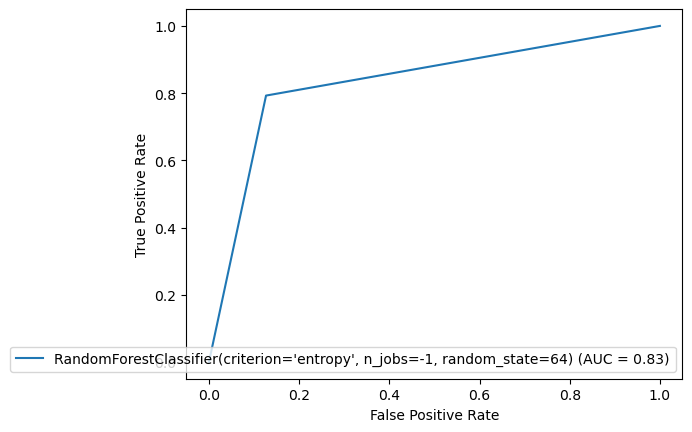

In [122]:
fpr,tpr, thresholds=metrics.roc_curve(y_test,pred)
roc_auc=metrics.auc(fpr,tpr)
disp=metrics.RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=roc_auc,estimator_name=final_model)
disp.plot()

# Creating the Final Model

In [123]:
final_model=RandomForestClassifier(criterion='entropy',n_estimators=100,n_jobs=-1,random_state=64)

In [124]:
final_model.fit(x_train,y_train)
pred=final_model.predict(x_test)
print('The accuracy using KNN is: {:4f}% '.format((accuracy_score(y_test,pred))*100))
print('Confusion Matrix:')
print(confusion_matrix(y_test,pred))
print('Classification report:')
print(classification_report(y_test,pred))

The accuracy using KNN is: 83.333333% 
Confusion Matrix:
[[145  21]
 [ 34 130]]
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       166
           1       0.86      0.79      0.83       164

    accuracy                           0.83       330
   macro avg       0.84      0.83      0.83       330
weighted avg       0.84      0.83      0.83       330



# Saving the model

Saving the model using joblib

In [125]:
import joblib

In [126]:
joblib.dump(final_model,'Titanic_survivour_prediction.pkl')

['Titanic_survivour_prediction.pkl']

Saving the model using pickle

In [127]:
import pickle

In [128]:
file='Titanic_survivour_prediction.pkl'
pickle.dump(final_model,open(file,'wb'))

Loading the file to test

In [130]:
test_model=pickle.load(open('Titanic_survivour_prediction.pkl','rb'))
predict=test_model.score(x_test,y_test)
print(predict)

0.8333333333333334


In [131]:
pd.DataFrame([test_model.predict(x_test)[:],y_test[:]],index=['Predict','Original'])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329
Predict,0,1,0,1,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,1,0,1,1,0,1,1,0,0,1,1,0,1,0,0,0,0,1,1,0,1,0,1,1,1,1,0,1,0,1,0,1,1,0,1,1,0,1,0,1,0,0,0,1,0,0,0,1,0,1,1,0,1,0,1,0,0,1,0,1,0,1,1,0,1,1,1,0,1,1,0,1,0,0,0,1,0,0,1,0,1,1,0,1,1,0,0,0,1,1,1,0,0,1,0,1,1,1,0,1,1,1,1,0,1,0,1,0,0,0,1,1,0,1,1,0,1,0,1,0,0,0,0,1,1,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,0,0,0,1,1,1,1,1,0,0,1,1,1,0,1,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,1,1,0,0,1,0,1,1,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,1,0,1,1,1,0,1,0,1,0,1,1,1,0
Original,1,1,1,1,0,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,0,0,1,0,0,1,0,1,1,0,0,1,1,1,1,0,1,0,0,1,1,0,1,1,1,1,1,1,1,1,0,1,0,1,1,0,1,1,0,1,1,1,0,0,0,1,0,0,0,0,1,1,1,0,1,0,1,0,0,0,0,1,0,1,1,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,0,0,1,1,1,0,0,1,0,0,1,0,0,1,1,1,1,0,1,0,1,0,1,0,1,1,0,1,1,0,1,1,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,1,0,1,1,1,1,0,0,0,1,0,0,0,1,1,1,0,1,1,1,0,0,1,1,1,0,0,1,0,1,0,1,0,0,1,1,1,0,1,0,0,0,0,1,1,0,1,1,1,0,1,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,1,1,0,0,1,0,1,1,1,1,0,0,1,0,0,1,0,1,1,1,1,0,1,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,1,0,1,0,1,0,1,0,1,0,1,1,1,0
